In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats.stats import pearsonr
from IPython.display import display, Markdown, Latex
plt.style.use('ggplot')
from datetime import timedelta
from dateutil.parser import parse
from datetime import date
import dask.dataframe as dd

data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_16682/1504765275.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


### Load mobility data files

### Load/Clean Simple Heatwave Data

In [73]:
heatwave_control = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/united_states/thi_heatwave_control_90.csv')



full_df = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/THI/united_states/daily_max_THI.csv')

full_df.rename(columns={'time': 'datetime'}, inplace=True)
full_df['datetime'] = pd.to_datetime(full_df['datetime'])
full_df['day'] = pd.DatetimeIndex(full_df['datetime']).day
full_df['month'] = pd.DatetimeIndex(full_df['datetime']).month
full_df['year'] = pd.DatetimeIndex(full_df['datetime']).year
full_df = full_df[~full_df['month'].isin([4, 10])]
full_df['location'] = full_df['adm2'] + ', ' + full_df['adm1']
full_df['datetime_ord'] = [date(x,y,z).toordinal() for x,y,z in zip(full_df['year'], full_df['month'], full_df['day'])]


In [79]:
us_shp = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/adm0_shp/united_states/UScounties.shp')


In [80]:
us_shp['FIPS'] = [x.replace('46113', '46102') for x in us_shp['FIPS']]
us_shp['location'] = us_shp['NAME'] + ', ' + us_shp['STATE_NAME']
us_shp = us_shp[['location', 'FIPS']]

In [81]:
full_df = full_df.merge(us_shp, on='location')
heatwave_control = heatwave_control.merge(us_shp, on='location')

<Axes: >

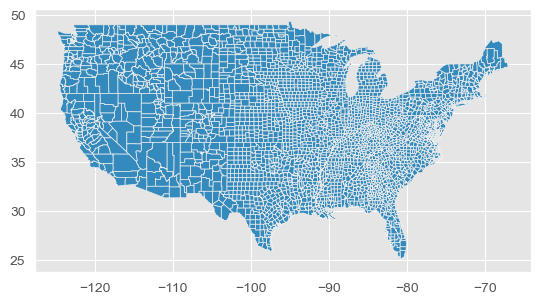

In [82]:
us_shp.merge(full_df.drop_duplicates('location'), on='location').plot()

In [83]:
heatwave_control['control_day'] = [parse(x) for x in heatwave_control['control_day']]
heatwave_control['datetime'] = [parse(x) for x in heatwave_control['datetime']]

In [84]:
(heatwave_control['datetime'] - heatwave_control['control_day']).describe()

count                         43251
mean     11 days 03:46:19.968093223
std       7 days 12:01:33.354627076
min              -42 days +00:00:00
25%                 7 days 00:00:00
50%                 7 days 00:00:00
75%                14 days 00:00:00
max                56 days 00:00:00
dtype: object

In [85]:
heatwave_control['diff'] = (heatwave_control['datetime'] - heatwave_control['control_day'])

In [86]:
temp = pd.DataFrame(heatwave_control['diff'].value_counts()).sort_index()

In [87]:
temp.columns = ['Number of Instances']

Text(0, 0.5, 'Heat and Control Difference')

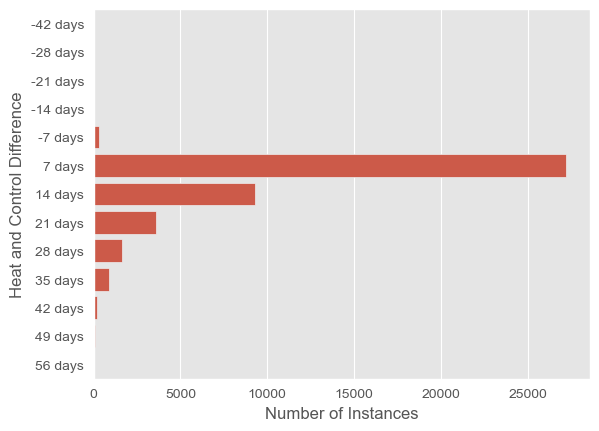

In [88]:
sns.barplot(temp, y=temp.index, x='Number of Instances')
plt.ylabel("Heat and Control Difference")

In [89]:
#load files

google = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/google_mobility/2022_US_Region_Mobility_Report.csv')
google.rename(columns = {'sub_region_2':'adm2', 
                                'sub_region_1': 'adm1', 
                                'retail_and_recreation_percent_change_from_baseline':'retail_rec', 
                                'grocery_and_pharmacy_percent_change_from_baseline':'grocery_pharm',
                                'parks_percent_change_from_baseline': 'parks', 
                                'transit_stations_percent_change_from_baseline': 'transit', 
                                'workplaces_percent_change_from_baseline':'workplaces',
                                'residential_percent_change_from_baseline': 'residential'}, inplace=True)
                                
                                
                                
                                



In [90]:
google

,country_region_code,country_region,adm1,adm2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_rec,grocery_pharm,parks,transit,workplaces,residential
0,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2022-01-01,-43.0,-33.0,-26.0,-41.0,-44.0,12.0
1,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2022-01-02,-20.0,-12.0,-26.0,-22.0,-17.0,7.0
2,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2022-01-03,-14.0,-1.0,-24.0,-32.0,-38.0,13.0
3,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2022-01-04,-14.0,1.0,-19.0,-30.0,-30.0,11.0
4,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2022-01-05,-16.0,0.0,-19.0,-32.0,-28.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747964,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,ChIJd4Rqhed3YocR7ubT5-HgoJg,2022-10-10,NaN,NaN,NaN,NaN,-26.0,NaN
747965,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,ChIJd4Rqhed3YocR7ubT5-HgoJg,2022-10-11,NaN,NaN,NaN,NaN,-20.0,NaN
747966,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,ChIJd4Rqhed3YocR7ubT5-HgoJg,2022-10-12,NaN,NaN,NaN,NaN,-17.0,NaN
747967,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,ChIJd4Rqhed3YocR7ubT5-HgoJg,2022-10-13,NaN,NaN,NaN,NaN,-15.0,NaN


In [91]:
google.dropna(subset='census_fips_code', inplace=True)
google['census_fips_code'] = google['census_fips_code'].astype(int)
google['census_fips_code'] = google['census_fips_code'].astype(str)
google['census_fips_code'] = ['0' + x if len(x) ==4 else x for x in google['census_fips_code']]

In [92]:
google.rename(columns = {'census_fips_code':'FIPS'}, inplace=True)

In [25]:
google['date'] = pd.to_datetime(google['date'])

In [35]:
mobility_heat = heatwave_control.merge(google[['date', 'FIPS', 'retail_rec', 'grocery_pharm', 'parks', 'transit', 'workplaces', 'residential']], left_on=['FIPS', 'datetime'], right_on=['FIPS', 'date'])

### Merge Mobility with Heat Data

In [36]:
#get mobility on control day
mobility_heat = mobility_heat.merge(google[['date', 'FIPS', 'retail_rec', 'grocery_pharm', 'parks', 'transit', 'workplaces', 'residential']], left_on=['FIPS', 'control_day'], right_on=['FIPS', 'date'], suffixes=['_heat', '_control'])

In [37]:
mobility_heat['location'] = mobility_heat['adm2'] + ', ' + mobility_heat['adm1']

In [38]:
#calculate differences between heat and control 
mobility_heat['retail_rec_difference'] = mobility_heat['retail_rec_heat'] - mobility_heat['retail_rec_control']
mobility_heat['grocery_pharm_difference'] = mobility_heat['grocery_pharm_heat'] - mobility_heat['grocery_pharm_control']
mobility_heat['parks_difference'] = mobility_heat['parks_heat'] - mobility_heat['parks_control']
mobility_heat['transit_difference'] = mobility_heat['transit_heat'] - mobility_heat['transit_control']
mobility_heat['workplaces_difference'] = mobility_heat['workplaces_heat'] - mobility_heat['workplaces_control']
mobility_heat['residential_difference'] = mobility_heat['residential_heat'] - mobility_heat['residential_control']

In [39]:
mobility_heat['day_of_week'] = [x.day_of_week for x in mobility_heat['date_heat']]
mobility_heat['weekend'] = [1 if x in [5,6] else 0 for x in mobility_heat['day_of_week']]

In [40]:
mobility_heat.reset_index(drop=True,inplace=True)

In [28]:
mobility_heat.to_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/united_states/THI_mobility_heat_clean_90.csv')